##### Imports

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage.filters as filters
import glob

##### Functions and definitions

In [89]:
def crop_big_circle(image,x, y, sq):
    return image[y-sq:y+sq, x-sq:x+sq]

def find_big_circle(image, ratio, minRadius, maxRadius):
    height, width = image.shape[:2]
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    output = image.copy()
    bigger_circle = cv2.HoughCircles(image=gray,
                                    method=cv2.HOUGH_GRADIENT,
                                    dp=3,
                                    minDist=width,
                                    maxRadius=int(width * maxRadius),
                                    minRadius=int(width * minRadius)) 

    if bigger_circle is not None:   
        # convert the (x, y) coordinates and radius of the circles to integers
        circlesRound = np.round(bigger_circle[0, :]).astype("int")
        # loop over the (x, y) coordinates and radius of the circles
        x, y, r = circlesRound[0]
        sq = int(r / np.sqrt(ratio))
        if sq > y: sq = y
        if sq > x: sq = x
        output = crop_big_circle(output, x, y, sq)
        return output, sq , np.array([x,y])
    else:
        raise Exception('No circles found')

def find_inner_circles(image, initial, center, sq, decay):
    height, width = image.shape[:2]
    # gray scaling the image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    output = initial.copy()
    maxRadius = int(1.4*(width/15))
    minRadius = int(0.6*(width/15))

    # finding small circles
    circles = cv2.HoughCircles(image=gray, 
                                   method=cv2.HOUGH_GRADIENT, 
                                   dp=1.2, 
                                   minDist=width / 4.6,
                                   param1=20,
                                   param2=16,
                                  minRadius=minRadius,
                                  maxRadius=maxRadius                           
                                  )

    if circles is not None:
        circlesRound = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circlesRound:
            cv2.circle(output, (x + (center[0] - sq), y+ (center[1] - sq)), int(r / decay), (0, 0, 0), 2)
    return output, np.round(circles[0, :]).astype("int")

def add_contrast(image, contrastBoost):
    clahe = cv2.createCLAHE(clipLimit=contrastBoost, tileGridSize=(8,8))
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)  # convert from BGR to LAB color space
    l, a, b = cv2.split(lab)  # split on 3 different channels
    l2 = clahe.apply(l)  # apply CLAHE to the L-channel
    lab = cv2.merge((l2,a,b))  # merge channels
    return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)  # convert from LAB to BGR

def division_norm(image):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    smooth = cv2.GaussianBlur(gray, (81,81), 0)
    division = cv2.divide(gray, smooth, scale=255)
    sharp = filters.unsharp_mask(division, radius=500, amount=4, preserve_range=False)
    sharp = (255*sharp).clip(0,255).astype(np.uint8)
    return cv2.cvtColor(sharp, cv2.COLOR_GRAY2BGR)

def binarize(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    opening = cv2.threshold(np.uint8(gray), 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
   
    cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    opening = 255 - opening
    for c in cnts:
        area = cv2.contourArea(c)
        
        if area < 100:
            cv2.drawContours(opening, [c], -1, 256, -1)
        else: 
            cv2.drawContours(opening, [c], -1, 256, -1)
            cv2.drawContours(opening, [c], -1, 0, 2)


    # Invert and apply slight Gaussian blur
    result = 255 - opening
    result = cv2.GaussianBlur(result, (5,5), 0)
    return cv2.cvtColor(result, cv2.COLOR_GRAY2BGR)

def calculate_SRID(path, outDir = 'res', contrastBoost = 4, decay = 1.03):
    image = cv2.imread(path)
    filename = path.split('\\')[-1]
    # proccessing the picture
    ratio = 1000/image.shape[1]
    image = cv2.resize(image,None,fx=ratio,fy=ratio)
    image_cropped, s1, c1 = find_big_circle(image, ratio=1.1, minRadius=0.45, maxRadius=0.6)
    sharp1 = add_contrast(image = np.uint8(image_cropped), contrastBoost = contrastBoost)
    sharp2 = division_norm(sharp1)
    # specify these values with accordance to the picture, ratio is the zooming factor, and keep the radius range tight for better performance 
    sharp2_c, s2, c2 = find_big_circle(sharp2, ratio=1.7, minRadius=0.45, maxRadius=0.6)
    binarized = binarize(sharp2_c)
    circles_on_black, circles = find_inner_circles(binarized, 255+np.zeros_like(binarized), [0,0], 0, decay)
    if circles is not None:
            for (x, y, r) in circles:
                cv2.circle(image_cropped, (x + (c2[0] - s2), y+ (c2[1] - s2)), int(r / decay), (0, 0, 0), 2)
    # sorting the data
    try:
        radius = circles[:,2] / ratio / decay
        circles = circles[:,:2]
        circles = np.hstack((circles, radius[:,np.newaxis]))
        circles = circles[circles[:, 0].argsort()]
        circles = np.reshape(circles, (4,4,3))
        c1 = circles[0]
        c2 = circles[1]
        c3 = circles[2]
        c4 = circles[3]
        c1 = c1[c1[:, 1].argsort()]
        c2 = c2[c2[:, 1].argsort()]
        c3 = c3[c3[:, 1].argsort()]
        c4 = c4[c4[:, 1].argsort()]
        circles = np.vstack((c1,c2,c3,c4))
    except: 
        print('was not expecting the number of found circles')
    # plotting the output
    _, ax = plt.subplots(2,3, figsize=(18,12))
    ax[0,0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0,0].set_title('Raw')
    ax[0,1].imshow(cv2.cvtColor(sharp1, cv2.COLOR_BGR2RGB))
    ax[0,1].set_title('Contrast boost')
    ax[0,2].imshow(cv2.cvtColor(sharp2_c, cv2.COLOR_BGR2RGB))
    ax[0,2].set_title('Black & White filter')
    ax[1,0].imshow(cv2.cvtColor(binarized, cv2.COLOR_BGR2RGB))
    ax[1,0].set_title('Outer contour detection, Noise reduction')
    ax[1,1].imshow(cv2.cvtColor(circles_on_black, cv2.COLOR_BGR2RGB))
    ax[1,1].set_title('Circle regression')
    ax[1,2].imshow(cv2.cvtColor(image_cropped, cv2.COLOR_BGR2RGB))
    ax[1,2].set_title('Final result')

    plt.savefig(outDir+"/out_" + filename.split(".")[0] + ".jpg", dpi=150, bbox_inches="tight")
    np.savetxt(outDir+"/out_" + filename.split(".")[0] + ".csv", circles, delimiter=",", fmt='%4d')

def calculate_All_SRID(inputDir, outputDir, fmt, contrastBoost):
    elements = glob.glob(inputDir + "/*." + fmt)
    for e in elements:
        calculate_SRID(path = e, outDir = outputDir, contrastBoost = contrastBoost)

#####  Execution command to run on the images inside the input folder

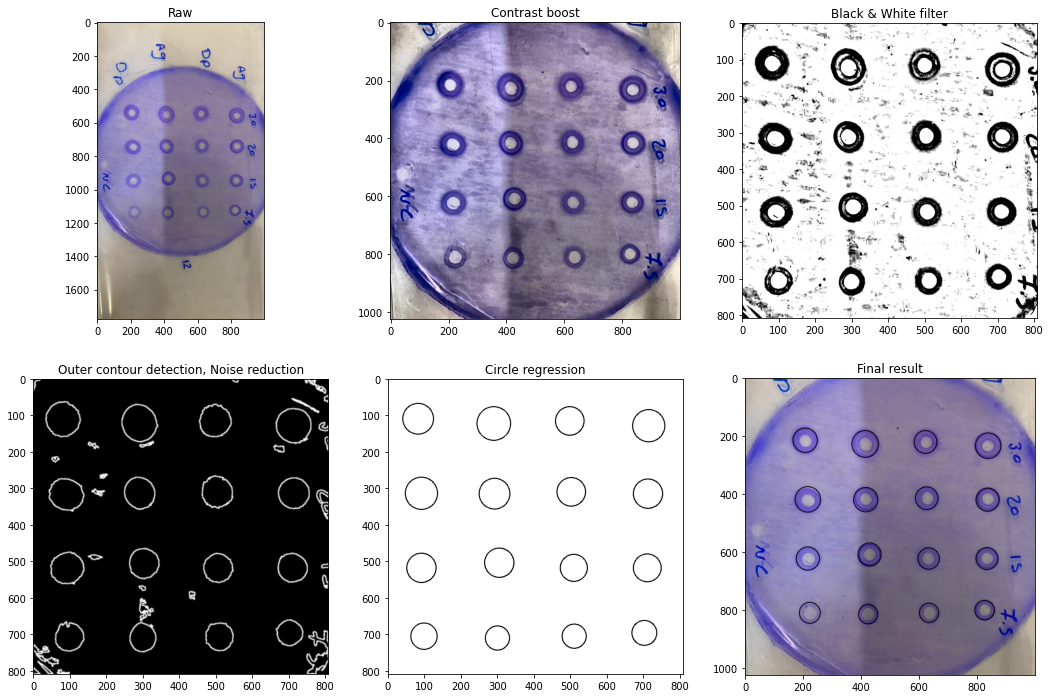

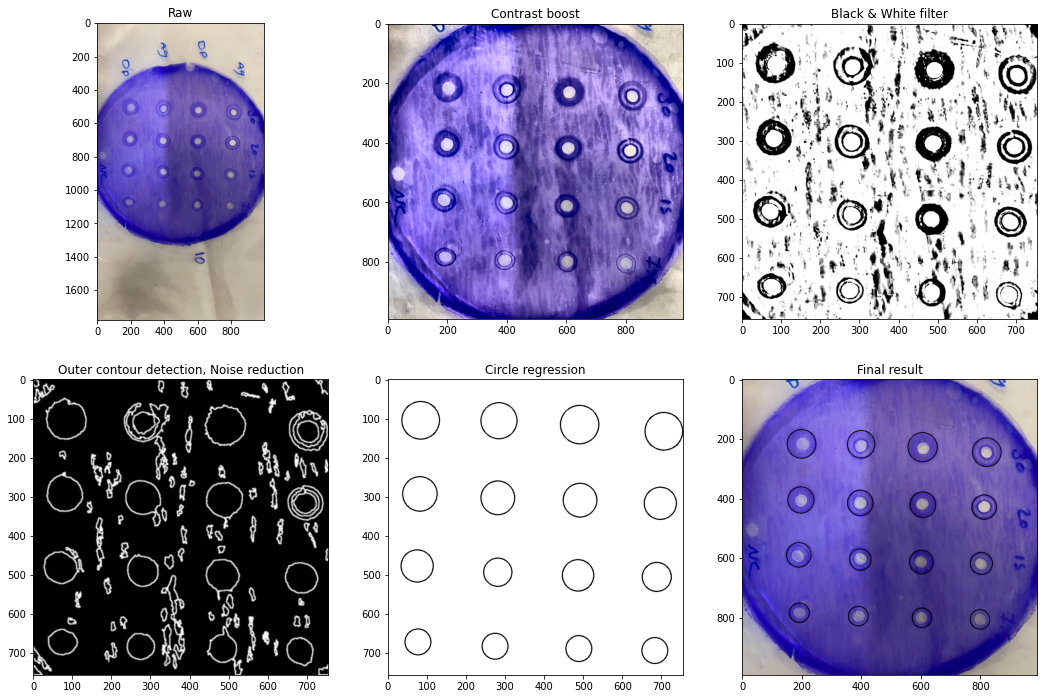

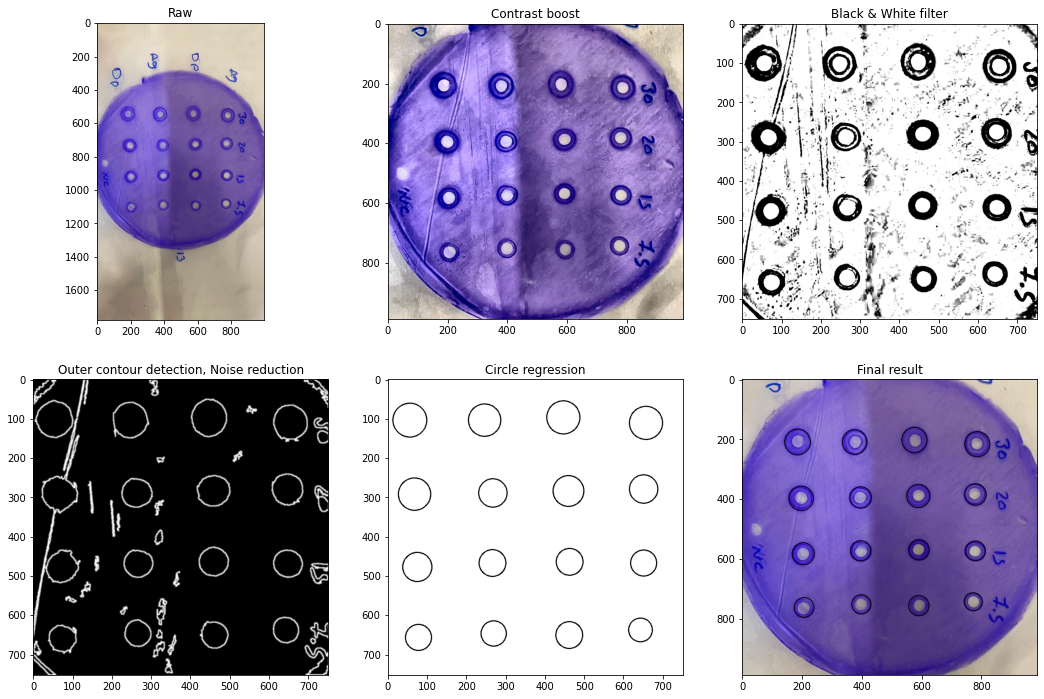

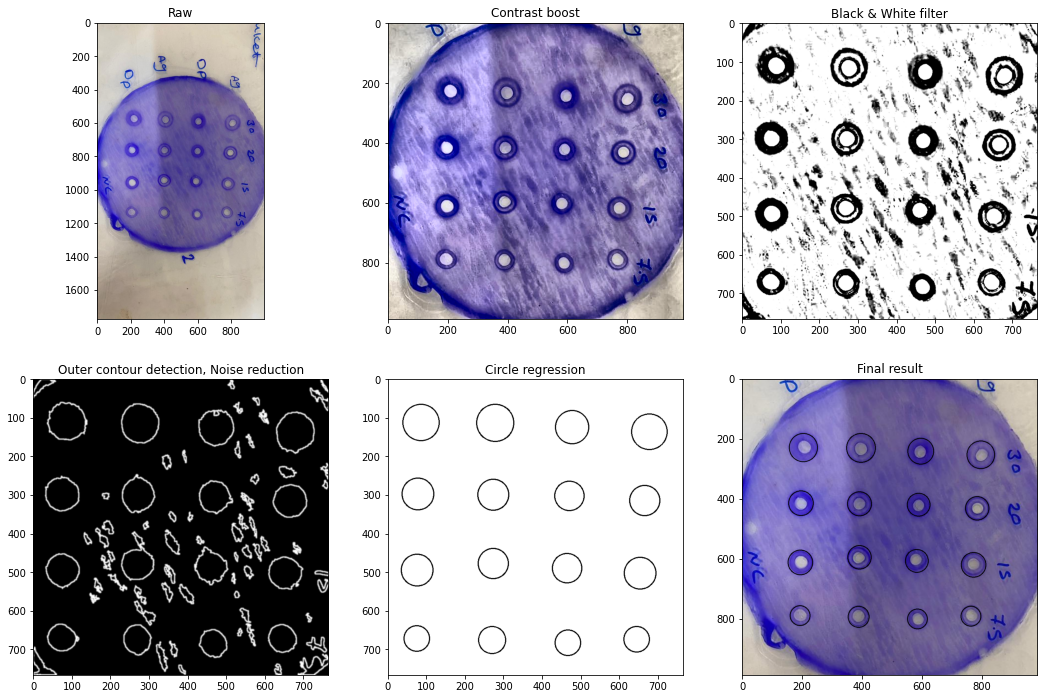

In [90]:
inDir = 'inputs'
outDir = 'res'
fmt = 'jpeg'
# increase this value if the inputes have lower contrasts
cBoost = 4
calculate_All_SRID(inputDir=inDir, outputDir=outDir, fmt=fmt, contrastBoost= cBoost)